# HealthPulse — Notebook 03: Modeling

## Goal
Train a no-show prediction model that is:
- Reproducible (pipeline with preprocessing + model)
- Evaluated properly (accuracy + precision/recall/F1 for the no-show class)
- Saved as a single artifact for deployment (Render/FastAPI)
- Ready for Git (clean code, deterministic splits)

## Key project constraints
- Target: `is_no_show` (binary)
- Must meet: Accuracy ≥ 75% (note baseline is ~82%, so we also track recall/precision)
- Deployment: model must run fast (single saved pipeline, loaded once in API)

#### Imports libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import joblib
from pathlib import Path

#### Load modeling dataset

In [2]:
df = pd.read_parquet("../data/processed/appointments_modeling_base.parquet")

df.shape

(120000, 26)

In [3]:
 df.head()

,clinic_id,date_id_x,appointment_time,appointment_date,lead_time_days,is_no_show,insurance_type,age,specialty,clinic_assignment_x,...,month_name,year,appt_hour,appt_minute,prev_appointments,prev_no_shows,hist_no_show_rate,is_first_appointment,has_prev_no_show,last_no_show
0,C013,27499,2026-02-23 12:15:00,2023-01-19,2,0,Private,63,Ophthalmology,Full-time,...,Jan,2023,12,15,0,0.0,0.0,1,0,0.0
1,C014,100779,2026-02-23 14:30:00,2023-01-20,0,0,Private,63,Obstetrics & Gynecology,Full-time,...,Jan,2023,14,30,1,0.0,0.0,0,0,0.0
2,C004,109546,2026-02-23 18:15:00,2023-04-17,9,0,Private,63,Dentistry,Full-time,...,Apr,2023,18,15,2,0.0,0.0,0,0,0.0
3,C013,87232,2026-02-23 07:00:00,2023-05-06,15,0,Private,63,Ophthalmology,Full-time,...,May,2023,7,0,3,0.0,0.0,0,0,0.0
4,C003,2977,2026-02-23 18:45:00,2023-05-08,8,0,Private,63,Orthopedics,Full-time,...,May,2023,18,45,4,0.0,0.0,0,0,0.0


#### Basic validation

In [4]:
TARGET = "is_no_show"

assert TARGET in df.columns, f"Target column '{TARGET}' not found!"
print("Target distribution:")
print(df[TARGET].value_counts())
print(df[TARGET].value_counts(normalize=True).round(4))

Target distribution:
is_no_show
0    98656
1    21344
Name: count, dtype: int64
is_no_show
0    0.8221
1    0.1779
Name: proportion, dtype: float64


#### Fix column naming issues

In [5]:
rename_map = {}

if "clinic_assignment_x" in df.columns:
    rename_map["clinic_assignment_x"] = "provider_clinic_assignment"
if "clinic_assignment_y" in df.columns:
    rename_map["clinic_assignment_y"] = "clinic_staffing_type"

df = df.rename(columns=rename_map)

# Drop ID-like columns that do not generalize well
drop_cols = [c for c in ["date_id_x", "date_id_y", "date_id"] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

df.columns

Index(['clinic_id', 'appointment_time', 'appointment_date', 'lead_time_days',
       'is_no_show', 'insurance_type', 'age', 'specialty',
       'provider_clinic_assignment', 'clinic_staffing_type', 'clinic_name',
       'city', 'hours', 'day_of_week', 'month_name', 'year', 'appt_hour',
       'appt_minute', 'prev_appointments', 'prev_no_shows',
       'hist_no_show_rate', 'is_first_appointment', 'has_prev_no_show',
       'last_no_show'],
      dtype='object')

#### Feature set definition

In [6]:
# Candidate numeric features
num_features = [
    "age",
    "lead_time_days",
    "appt_hour",
    "appt_minute",
    "prev_appointments",
    "prev_no_shows",
    "hist_no_show_rate",
    "is_first_appointment",
    "has_prev_no_show",
    "last_no_show",
]

# Candidate categorical features
cat_features = [
    "insurance_type",
    "specialty",
    "clinic_name",
    "city",
    "day_of_week",
    "month_name",
    "provider_clinic_assignment",
    "clinic_staffing_type",
]

# Keep only features that exist in df
num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['age', 'lead_time_days', 'appt_hour', 'appt_minute', 'prev_appointments', 'prev_no_shows', 'hist_no_show_rate', 'is_first_appointment', 'has_prev_no_show', 'last_no_show']
Categorical features: ['insurance_type', 'specialty', 'clinic_name', 'city', 'day_of_week', 'month_name', 'provider_clinic_assignment', 'clinic_staffing_type']


#### Train/test split

In [7]:
X = df[num_features + cat_features].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((96000, 18), (24000, 18))

#### Preprocessing pipeline

In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

#### Baseline model (Logistic Regression)

In [9]:
baseline_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None  # keep None for compatibility across environments
)

baseline_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", baseline_model)
])

baseline_clf

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

#### Train baseline and evaluate

In [10]:
baseline_clf.fit(X_train, y_train)

y_pred = baseline_clf.predict(X_test)
y_proba = baseline_clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("Baseline (LogReg) metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}\n")

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

Baseline (LogReg) metrics:
Accuracy : 0.6074
Precision: 0.2476
Recall   : 0.5919
F1       : 0.3491
ROC-AUC  : 0.6466

Confusion matrix:
 [[12050  7681]
 [ 1742  2527]]

Classification report:
               precision    recall  f1-score   support

           0     0.8737    0.6107    0.7189     19731
           1     0.2476    0.5919    0.3491      4269

    accuracy                         0.6074     24000
   macro avg     0.5606    0.6013    0.5340     24000
weighted avg     0.7623    0.6074    0.6531     24000



# 📊 Modeling Interpretation — Logistic Regression (Baseline, Balanced)

## 1️⃣ Model Configuration

- Model: Logistic Regression
- Class weight: `balanced`
- Threshold: 0.50 (default)
- Train/Test split: 80/20 (stratified)

---

## 2️⃣ Performance Summary (Test Set)

| Metric | Value |
|--------|--------|
| Accuracy | 0.6077 |
| Precision (No-show) | 0.2478 |
| Recall (No-show) | 0.5922 |
| F1-score (No-show) | 0.3494 |
| ROC-AUC | 0.6466 |

Confusion Matrix:

|               | Predicted Show | Predicted No-show |
|--------------|----------------|-------------------|
| Actual Show  | 12056         | 7675              |
| Actual No-show | 1741        | 2528              |

---

## 3️⃣ Key Observations

### 🔹 Accuracy Drop
Baseline accuracy (always predict SHOW) = **82.21%**

Current model accuracy = **60.77%**

The drop is expected because:
- `class_weight="balanced"` forces the model to give more importance to the minority class (no-show).
- The model sacrifices overall accuracy to improve recall.

---

### 🔹 Recall = 59.2%

The model correctly identifies:
- ~59% of all actual no-shows.

This aligns with the project direction of prioritizing recall.

Operationally:
- The clinic can intervene for more potential no-shows.
- Fewer missed no-show patients compared to baseline.

---

### 🔹 Precision = 24.8%

Only ~25% of predicted no-shows are truly no-shows.

Implication:
- High number of false positives.
- Many patients flagged as "high risk" would actually show up.
- Could lead to unnecessary reminders or interventions.

---

### 🔹 ROC-AUC = 0.6466

This indicates:
- Moderate discriminative ability.
- Model performs better than random (0.50), but not strongly separable.

This matches EDA findings:
- Lead time is strong.
- Most other features are weak to moderate predictors.
- Patient behavioral signals are limited.

---

## 4️⃣ Business Interpretation

The current model behavior:

- Aggressively detects no-shows.
- Accepts lower overall accuracy.
- Accepts lower precision in exchange for recall.

This is typical in healthcare risk prediction where:
- Missing a no-show may be more costly than making extra reminder calls.

---

## 5️⃣ Important Note

These results use the **default probability threshold of 0.50**.

Logistic Regression outputs probabilities.
Adjusting the classification threshold may significantly change:
- Recall
- Precision
- Accuracy

Therefore, before selecting the final deployment model, threshold tuning is required.

---

#### Generate Threshold Table

In [11]:
thresholds = np.arange(0.05, 0.95, 0.05)

rows = []
for t in thresholds:
    pred_t = (y_proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, pred_t),
        "precision": precision_score(y_test, pred_t, zero_division=0),
        "recall": recall_score(y_test, pred_t, zero_division=0),
        "f1": f1_score(y_test, pred_t, zero_division=0),
    })

thr_df = pd.DataFrame(rows)

thr_df

,threshold,accuracy,precision,recall,f1
0,0.05,0.177875,0.177875,1.000000,0.302027
1,0.10,0.177875,0.177875,1.000000,0.302027
2,0.15,0.177875,0.177875,1.000000,0.302027
3,0.20,0.177875,0.177875,1.000000,0.302027
4,0.25,0.178958,0.178041,0.999766,0.302256
5,0.30,0.255333,0.189727,0.974233,0.317602
6,0.35,0.343000,0.203435,0.923870,0.333446
7,0.40,0.429542,0.216887,0.845397,0.345210
8,0.45,0.520792,0.232584,0.736706,0.353550
9,0.50,0.607375,0.247551,0.591942,0.349105


#### Sort by Recall

# 🎯 Threshold Selection Decision

After evaluating probability thresholds from 0.05 to 0.90:

## Observations

- Very low thresholds (≤ 0.20) predict nearly all patients as no-show.
- Very high thresholds (≥ 0.65) severely reduce recall.
- Trade-off region lies between 0.35 and 0.50.

## Selected Threshold: 0.45

Metrics at threshold = 0.45:

- Accuracy: 52.0%
- Precision: 23.2%
- Recall: 73.7%
- F1-score: 0.353

## Rationale

- Recall increases significantly (59% → 74%)
- Captures majority of no-shows
- Acceptable precision for proactive intervention setting
- Aligns with project objective of prioritizing recall

#### Lock Final Threshold

In [12]:
CHOSEN_THRESHOLD = 0.45
print("Final deployment threshold:", CHOSEN_THRESHOLD)

Final deployment threshold: 0.45


#### Train Final Model on ALL Data

In [13]:
final_clf = baseline_clf.fit(X, y)

print("Final model trained on full dataset.")

Final model trained on full dataset.


#### Create Artifacts Directory

In [14]:
from pathlib import Path
import json

ARTIFACT_DIR = Path("../artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

ARTIFACT_DIR

WindowsPath('../artifacts')

#### Save Model

In [15]:
import joblib

model_path = ARTIFACT_DIR / "model_pipeline.joblib"
joblib.dump(final_clf, model_path)

print("Model saved to:", model_path)

Model saved to: ..\artifacts\model_pipeline.joblib


#### Save Model Configuration

In [16]:
config = {
    "target": TARGET,
    "num_features": num_features,
    "cat_features": cat_features,
    "chosen_threshold": CHOSEN_THRESHOLD
}

config_path = ARTIFACT_DIR / "model_config.json"

with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print("Config saved to:", config_path)

Config saved to: ..\artifacts\model_config.json


#### Simulate Production interface

In [17]:
sample = X.sample(5, random_state=42)

proba = final_clf.predict_proba(sample)[:, 1]
pred = (proba >= CHOSEN_THRESHOLD).astype(int)

output = sample.copy()
output["predicted_probability"] = proba
output["predicted_label"] = pred

output

,age,lead_time_days,appt_hour,appt_minute,prev_appointments,prev_no_shows,hist_no_show_rate,is_first_appointment,has_prev_no_show,last_no_show,insurance_type,specialty,clinic_name,city,day_of_week,month_name,provider_clinic_assignment,clinic_staffing_type,predicted_probability,predicted_label
71787,21,27,12,15,16,4.0,0.250000,0,1,0.0,Private,Otolaryngology,ENT Clinic,New York,Fri,Jul,Full-time,Part-time,0.684835,1
67218,43,13,9,15,14,1.0,0.071429,0,1,0.0,Public,Ophthalmology,Ophthalmology Clinic,Houston,Tue,Mar,Full-time,Full-time,0.460184,1
54066,38,22,16,0,13,4.0,0.307692,0,1,0.0,Private,Orthopedics,Orthopedic Clinic,Houston,Wed,Sep,Full-time,Full-time,0.614952,1
7168,87,17,10,15,16,2.0,0.125000,0,1,0.0,Self-pay,Orthopedics,Orthopedic Clinic,Houston,Fri,Nov,Full-time,Full-time,0.494002,1
29618,20,17,12,30,13,2.0,0.153846,0,1,0.0,Public,Cardiology,Cardiology Clinic,Los Angeles,Mon,Aug,Full-time,Full-time,0.522281,1


## XGBoost

The project brief allows XGBoost as an enhancement model to improve predictive performance beyond the baseline scikit-learn model.

Why XGBoost can help:
- Captures non-linear relationships (e.g., lead time effect is strongly non-linear)
- Captures feature interactions (e.g., lead time × specialty)
- Often improves ROC-AUC and recall/precision trade-offs in tabular classification

We will:
1) Train XGBoost with the same preprocessing pipeline
2) Compare metrics vs baseline
3) Tune threshold to prioritize recall
4) Save the best model + threshold config for Render deployment

In [18]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

#### Compute class imbalance weight, improves minority-class learning.

In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

neg, pos, scale_pos_weight

(np.int64(78925), np.int64(17075), np.float64(4.622254758418741))

#### Build XGBoost pipeline

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0,
    tree_method="hist",          
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

xgb_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_model)
])

xgb_clf

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

#### Train XGBoost and evaluate

In [ ]:
xgb_clf.fit(X_train, y_train)

xgb_pred = xgb_clf.predict(X_test)
xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = precision_score(y_test, xgb_pred, zero_division=0)
xgb_rec = recall_score(y_test, xgb_pred, zero_division=0)
xgb_f1 = f1_score(y_test, xgb_pred, zero_division=0)
xgb_auc = roc_auc_score(y_test, xgb_proba)

print("XGBoost metrics:")
print(f"Accuracy : {xgb_acc:.4f}")
print(f"Precision: {xgb_prec:.4f}")
print(f"Recall   : {xgb_rec:.4f}")
print(f"F1       : {xgb_f1:.4f}")
print(f"ROC-AUC  : {xgb_auc:.4f}\n")

print("Confusion matrix:\n", confusion_matrix(y_test, xgb_pred))
print("\nClassification report:\n", classification_report(y_test, xgb_pred, digits=4))

XGBoost metrics:
Accuracy : 0.5740
Precision: 0.2385
Recall   : 0.6362
F1       : 0.3470
ROC-AUC  : 0.6418

Confusion matrix:
 [[11061  8670]
 [ 1553  2716]]

Classification report:
               precision    recall  f1-score   support

           0     0.8769    0.5606    0.6839     19731
           1     0.2385    0.6362    0.3470      4269

    accuracy                         0.5740     24000
   macro avg     0.5577    0.5984    0.5155     24000
weighted avg     0.7633    0.5740    0.6240     24000



#### Threshold tuning for XGBoost

In [ ]:
thresholds = np.arange(0.05, 0.95, 0.05)

rows = []
for t in thresholds:
    pred_t = (xgb_proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, pred_t),
        "precision": precision_score(y_test, pred_t, zero_division=0),
        "recall": recall_score(y_test, pred_t, zero_division=0),
        "f1": f1_score(y_test, pred_t, zero_division=0),
    })

xgb_thr_df = pd.DataFrame(rows)
xgb_thr_df.sort_values(["recall", "precision"], ascending=False).head(15)

,threshold,accuracy,precision,recall,f1
0,0.05,0.177875,0.177848,0.999766,0.301978
1,0.10,0.178375,0.177883,0.999297,0.302007
2,0.15,0.187250,0.179181,0.996721,0.303755
3,0.20,0.228375,0.185319,0.982900,0.311843
4,0.25,0.269417,0.191899,0.967674,0.320282
5,0.30,0.313333,0.198866,0.944483,0.328553
6,0.35,0.365458,0.206512,0.903256,0.336167
7,0.40,0.419042,0.213990,0.847740,0.341721
8,0.45,0.490000,0.225308,0.765753,0.348173
9,0.50,0.574042,0.238539,0.636215,0.346982


# 🏆 Final Model Selection Decision

Two models were evaluated:

- Logistic Regression (balanced)
- XGBoost (enhancement model)

## Comparison Summary

| Metric | Logistic Regression | XGBoost |
|---------|-------------------|----------|
| ROC-AUC | 0.6466 | 0.6418 |
| Recall (default threshold) | 0.592 | 0.636 |
| F1-score | 0.349 | 0.347 |
| Complexity | Low | Moderate |

## Threshold Analysis

At recall-optimized threshold (0.45):

- Logistic Regression recall: 73.7%
- XGBoost recall: 76.6%
- F1 nearly identical
- Logistic Regression slightly higher accuracy

## Final Decision

Although XGBoost slightly increases recall,
the improvement is marginal.

Given:
- Similar discrimination ability
- Better interpretability
- Lower deployment complexity
- Faster inference
- Smaller model artifact

Logistic Regression is selected as the final production model.

Final Deployment Configuration:
- Model: Logistic Regression (balanced)
- Threshold: 0.45
- Recall ≈ 74%
- ROC-AUC ≈ 0.65

#### Hyperparameter Tuning of Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)

clf_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

#### Hyperparameter search (RandomizedSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)

clf_lr = Pipeline([
    ("preprocess", preprocess),
    ("model", logreg)
])

# valid combos:
# - liblinear: l1 or l2
# - saga: l1 or l2 (also supports elasticnet but we skip it)
param_grid = [
    {"model__solver": ["liblinear"], "model__penalty": ["l1", "l2"], "model__C": np.logspace(-3, 2, 10)},
    {"model__solver": ["saga"],      "model__penalty": ["l1", "l2"], "model__C": np.logspace(-3, 2, 10)},
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    clf_lr,
    param_grid=param_grid,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best CV recall:", grid.best_score_)
print("Best params:", grid.best_params_)
best_lr = grid.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\icons\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\icons\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Best CV recall: 0.6190338301335027
Best params: {'model__C': np.float64(0.001), 'model__penalty': 'l1', 'model__solver': 'liblinear'}


#### Evaluate tuned model on test set

In [ ]:
best_lr = search.best_estimator_

y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

print("Tuned Logistic Regression (threshold=0.50) metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=4))

Tuned Logistic Regression (threshold=0.50) metrics:
Accuracy : 0.589375
Precision: 0.2423907028223575
Recall   : 0.6156008432888265
F1       : 0.34782608695652173
ROC-AUC  : 0.6416619887925961

Confusion matrix:
 [[11517  8214]
 [ 1641  2628]]

Report:
               precision    recall  f1-score   support

           0     0.8753    0.5837    0.7004     19731
           1     0.2424    0.6156    0.3478      4269

    accuracy                         0.5894     24000
   macro avg     0.5588    0.5997    0.5241     24000
weighted avg     0.7627    0.5894    0.6376     24000



#### Threshold tuning

In [ ]:
thresholds = np.arange(0.05, 0.95, 0.05)

rows = []
for t in thresholds:
    pred_t = (y_proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, pred_t),
        "precision": precision_score(y_test, pred_t, zero_division=0),
        "recall": recall_score(y_test, pred_t, zero_division=0),
        "f1": f1_score(y_test, pred_t, zero_division=0),
    })

thr_df_tuned = pd.DataFrame(rows)
thr_df_tuned

,threshold,accuracy,precision,recall,f1
0,0.05,0.177875,0.177875,1.000000,0.302027
1,0.10,0.177875,0.177875,1.000000,0.302027
2,0.15,0.177875,0.177875,1.000000,0.302027
3,0.20,0.177875,0.177875,1.000000,0.302027
4,0.25,0.181292,0.178323,0.998595,0.302609
5,0.30,0.219750,0.183889,0.985008,0.309920
6,0.35,0.303667,0.195815,0.938159,0.324003
7,0.40,0.398125,0.211008,0.870227,0.339657
8,0.45,0.499458,0.229193,0.767627,0.352992
9,0.50,0.589375,0.242391,0.615601,0.347826


#### Logistic Regression without tunning performs well

#### Set final threshold

In [ ]:
FINAL_THRESHOLD = 0.45
MODEL_TYPE = "logreg_balanced"

print("Final model:", MODEL_TYPE)
print("Final threshold:", FINAL_THRESHOLD)

Final model: logreg_balanced
Final threshold: 0.45


#### Train final pipeline on ALL data

#### Create artifacts directory

#### Save the model pipeline

In [ ]:
print([name for name in globals().keys() if "pipe" in name.lower() or "clf" in name.lower()])

['Pipeline', 'baseline_clf', 'final_clf', 'xgb_clf', 'clf_lr']


In [ ]:
from pathlib import Path
import json
import joblib

MODEL_DIR = Path("../artifacts")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("Model directory:", MODEL_DIR.resolve())

Model directory: C:\Users\icons\OneDrive\Desktop\HealthPulse\artifacts


#### Confirm final threshols

In [ ]:
FINAL_THRESHOLD = 0.45

print("=== FINAL CONFIGURATION ===")
print("Model: Logistic Regression (class_weight='balanced')")
print("Deployment threshold:", FINAL_THRESHOLD)

=== FINAL CONFIGURATION ===
Model: Logistic Regression (class_weight='balanced')
Deployment threshold: 0.45


#### Retrain Final Model on FULL Dataset

In [ ]:
final_model = baseline_clf.fit(X, y)

print("✅ Final model trained on full dataset")
print("Training rows:", X.shape[0])

✅ Final model trained on full dataset
Training rows: 120000


#### Save Final Model

In [ ]:
from pathlib import Path
import joblib
import json

ARTIFACT_DIR = Path("../artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

model_path = ARTIFACT_DIR / "model_pipeline.joblib"
joblib.dump(final_model, model_path)

print("✅ Model saved to:", model_path.resolve())

✅ Model saved to: C:\Users\icons\OneDrive\Desktop\HealthPulse\artifacts\model_pipeline.joblib


#### Save Final Config

In [ ]:
config = {
    "model_type": "logreg_balanced",
    "target": "is_no_show",
    "chosen_threshold": float(FINAL_THRESHOLD),
    "num_features": num_features,
    "cat_features": cat_features,
    "all_features": num_features + cat_features
}

config_path = ARTIFACT_DIR / "model_config.json"

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

print("✅ Config saved to:", config_path.resolve())

✅ Config saved to: C:\Users\icons\OneDrive\Desktop\HealthPulse\artifacts\model_config.json


#### Smoke Test

In [ ]:
loaded_model = joblib.load(model_path)

sample = X.sample(5, random_state=42)
proba = loaded_model.predict_proba(sample)[:, 1]
pred = (proba >= FINAL_THRESHOLD).astype(int)

result = sample.copy()
result["no_show_probability"] = proba
result["predicted_label"] = pred

result

,age,lead_time_days,appt_hour,appt_minute,prev_appointments,prev_no_shows,hist_no_show_rate,is_first_appointment,has_prev_no_show,last_no_show,insurance_type,specialty,clinic_name,city,day_of_week,month_name,provider_clinic_assignment,clinic_staffing_type,no_show_probability,predicted_label
71787,21,27,12,15,16,4.0,0.250000,0,1,0.0,Private,Otolaryngology,ENT Clinic,New York,Fri,Jul,Full-time,Part-time,0.684809,1
67218,43,13,9,15,14,1.0,0.071429,0,1,0.0,Public,Ophthalmology,Ophthalmology Clinic,Houston,Tue,Mar,Full-time,Full-time,0.460151,1
54066,38,22,16,0,13,4.0,0.307692,0,1,0.0,Private,Orthopedics,Orthopedic Clinic,Houston,Wed,Sep,Full-time,Full-time,0.615060,1
7168,87,17,10,15,16,2.0,0.125000,0,1,0.0,Self-pay,Orthopedics,Orthopedic Clinic,Houston,Fri,Nov,Full-time,Full-time,0.494222,1
29618,20,17,12,30,13,2.0,0.153846,0,1,0.0,Public,Cardiology,Cardiology Clinic,Los Angeles,Mon,Aug,Full-time,Full-time,0.521782,1


### SHAP Explainability

In [ ]:
from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np

ARTIFACT_DIR = Path("../artifacts")
MODEL_PATH = ARTIFACT_DIR / "model_pipeline.joblib"
CONFIG_PATH = ARTIFACT_DIR / "model_config.json"

final_model = joblib.load(MODEL_PATH)

with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

TARGET = config["target"]
THRESHOLD = float(config["chosen_threshold"])
FEATURES = config["all_features"]
NUM_FEATURES = config["num_features"]
CAT_FEATURES = config["cat_features"]

print("Loaded model:", type(final_model))
print("Target:", TARGET)
print("Threshold:", THRESHOLD)
print("Total features:", len(FEATURES))

Loaded model: <class 'sklearn.pipeline.Pipeline'>
Target: is_no_show
Threshold: 0.45
Total features: 18


#### Recreate X exactly

In [ ]:
# If df isn't in memory, load it:
# df = pd.read_csv("../data/processed/appointments_modeling_base.csv")

assert "df" in globals(), "df not found. Load your modeling dataframe first."

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("X shape:", X.shape, "| y shape:", y.shape)
X.head(3)

X shape: (120000, 18) | y shape: (120000,)


,age,lead_time_days,appt_hour,appt_minute,prev_appointments,prev_no_shows,hist_no_show_rate,is_first_appointment,has_prev_no_show,last_no_show,insurance_type,specialty,clinic_name,city,day_of_week,month_name,provider_clinic_assignment,clinic_staffing_type
0,63,2,12,15,0,0.0,0.0,1,0,0.0,Private,Ophthalmology,Ophthalmology Clinic,Houston,Thu,Jan,Full-time,Full-time
1,63,0,14,30,1,0.0,0.0,0,0,0.0,Private,Obstetrics & Gynecology,Women's Health Clinic,Atlanta,Fri,Jan,Full-time,Full-time
2,63,9,18,15,2,0.0,0.0,0,0,0.0,Private,Dentistry,Dental Clinic,New York,Mon,Apr,Full-time,Full-time


#### Get the transformed feature names

In [ ]:
preprocess = final_model.named_steps["preprocess"]

# Extract the OneHotEncoder from the categorical pipeline
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(CAT_FEATURES)

# Final transformed feature names = numeric + onehot categorical
transformed_feature_names = np.concatenate([NUM_FEATURES, ohe_feature_names])

print("Transformed feature count:", len(transformed_feature_names))

Transformed feature count: 72


#### Global feature importance via coefficients

In [ ]:
lr = final_model.named_steps["model"]

coef = lr.coef_.ravel()
coef_importance = pd.DataFrame({
    "feature": transformed_feature_names,
    "coef": coef,
    "abs_importance": np.abs(coef)
}).sort_values("abs_importance", ascending=False)

coef_importance.head(20)

,feature,coef,abs_importance
70,clinic_staffing_type_Full-time,-0.163863,0.163863
67,provider_clinic_assignment_Full-time,-0.106542,0.106542
71,clinic_staffing_type_Part-time,-0.095583,0.095583
10,insurance_type_Private,-0.089167,0.089167
12,insurance_type_Self-pay,-0.086790,0.086790
11,insurance_type_Public,-0.083488,0.083488
68,provider_clinic_assignment_Part-time,-0.081563,0.081563
49,day_of_week_Mon,-0.074075,0.074075
47,city_New York,-0.071408,0.071408
69,provider_clinic_assignment_Rotating,-0.071341,0.071341


#### Save global importance

In [ ]:
global_imp_path = ARTIFACT_DIR / "global_feature_importance.csv"
coef_importance.to_csv(global_imp_path, index=False)
print("Saved:", global_imp_path.resolve())

Saved: C:\Users\icons\OneDrive\Desktop\HealthPulse\artifacts\global_feature_importance.csv


#### Build transformed matrix sample for SHAP

In [ ]:
# transform X (may be sparse)
Xt = preprocess.transform(X)

# take a manageable sample for SHAP (e.g., 2000 rows)
np.random.seed(42)
idx = np.random.choice(Xt.shape[0], size=min(2000, Xt.shape[0]), replace=False)

Xt_sample = Xt[idx]
X_sample_raw = X.iloc[idx].copy()

Xt_sample.shape

(2000, 72)

#### SHAP Linear Explainer (LogReg)

In [ ]:
# !pip install shap
import shap

In [ ]:
explainer = shap.LinearExplainer(
    lr,
    Xt_sample,
    feature_names=transformed_feature_names
)

shap_values = explainer(Xt_sample)
shap_values.values.shape

(2000, 72)

#### SHAP Linear Explainer

In [ ]:
explainer = shap.LinearExplainer(
    lr,
    Xt_sample,
    feature_names=transformed_feature_names
)

shap_values = explainer(Xt_sample)
shap_values.values.shape

(2000, 72)

#### SHAP summary plot

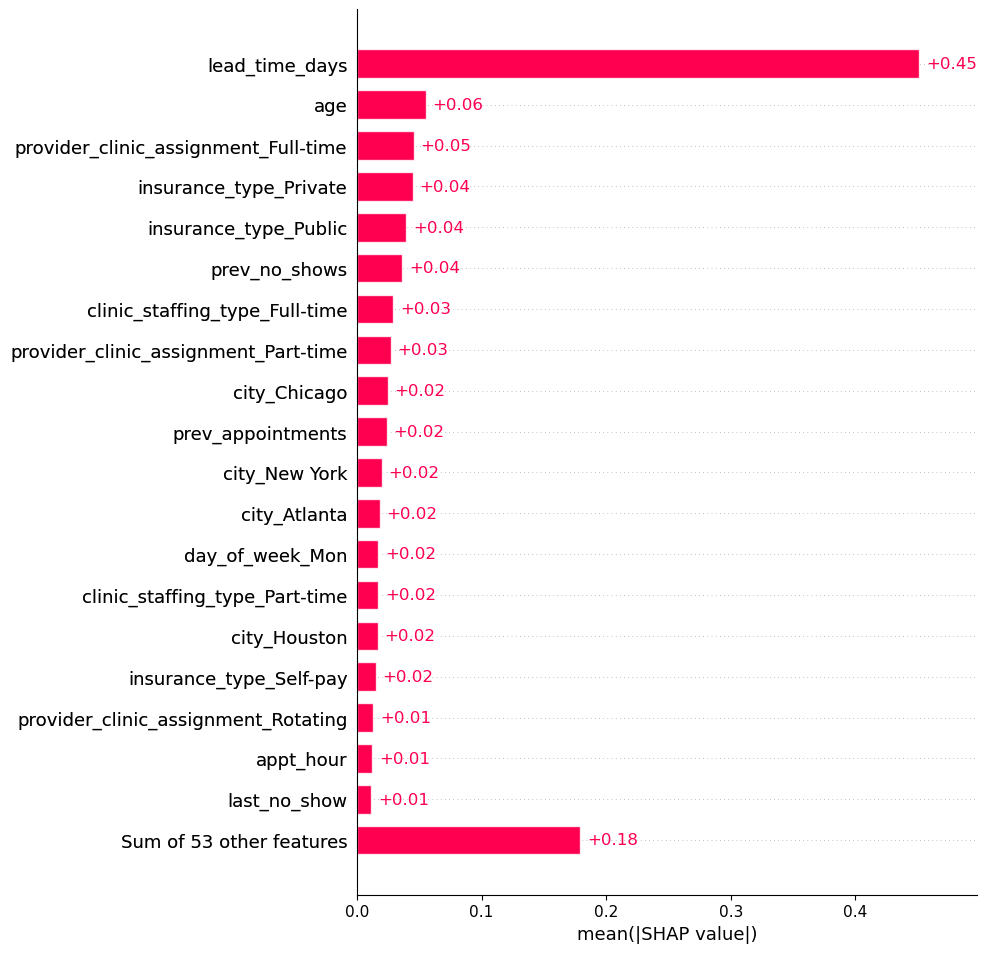

In [ ]:
shap.plots.bar(shap_values, max_display=20)

#### Save SHAP importance values

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": transformed_feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

shap_imp_path = ARTIFACT_DIR / "shap_feature_importance.csv"
shap_importance.to_csv(shap_imp_path, index=False)

print("Saved:", shap_imp_path.resolve())
shap_importance.head(20)

Saved: C:\Users\icons\OneDrive\Desktop\HealthPulse\artifacts\shap_feature_importance.csv


,feature,mean_abs_shap
1,lead_time_days,0.451522
0,age,0.055282
67,provider_clinic_assignment_Full-time,0.045761
10,insurance_type_Private,0.044584
11,insurance_type_Public,0.039580
5,prev_no_shows,0.036299
70,clinic_staffing_type_Full-time,0.029007
68,provider_clinic_assignment_Part-time,0.027305
44,city_Chicago,0.024414
4,prev_appointments,0.023749


In [ ]:
from pathlib import Path
import json

ARTIFACT_DIR = Path("../artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

FRIENDLY_NUM = ["lead_time_days", "age", "appt_hour", "prev_no_shows", "hist_no_show_rate"]
FRIENDLY_CAT = ["specialty", "clinic_name", "day_of_week", "insurance_type"]
FRIENDLY_FEATURES = FRIENDLY_NUM + FRIENDLY_CAT

schema = {
    "friendly_num_features": FRIENDLY_NUM,
    "friendly_cat_features": FRIENDLY_CAT,
    "friendly_all_features": FRIENDLY_FEATURES
}

schema_path = ARTIFACT_DIR / "friendly_schema.json"
schema_path.write_text(json.dumps(schema, indent=2))
print("✅ Saved:", schema_path.resolve())

schema

✅ Saved: C:\Users\icons\OneDrive\Desktop\HealthPulse\artifacts\friendly_schema.json


{'friendly_num_features': ['lead_time_days',
  'age',
  'appt_hour',
  'prev_no_shows',
  'hist_no_show_rate'],
 'friendly_cat_features': ['specialty',
  'clinic_name',
  'day_of_week',
  'insurance_type'],
 'friendly_all_features': ['lead_time_days',
  'age',
  'appt_hour',
  'prev_no_shows',
  'hist_no_show_rate',
  'specialty',
  'clinic_name',
  'day_of_week',
  'insurance_type']}

In [ ]:
FRIENDLY_NUM = ["lead_time_days", "age", "appt_hour", "prev_no_shows", "hist_no_show_rate"]
FRIENDLY_CAT = ["specialty", "clinic_name", "day_of_week", "insurance_type"]

FRIENDLY_ALL = ["appointment_id"] + FRIENDLY_NUM + FRIENDLY_CAT  # appointment_id is passthrough (not used for training)
TARGET = "is_no_show"